In [24]:
from ipywidgets import Datetime
from typing import List, Tuple
from Model.Betting.bet import Bet
import numpy as np
from numpy import cumsum
import time

def plot_cumsum_over_time(values: List[float], times: List[Datetime], axis, label, color: str, linestyle: str, starting_bankroll: float = 1500):
    cumsum_values = cumsum(values) + starting_bankroll
    
    sns.lineplot(ax=axis, x=times, y=cumsum_values, label=label, color=color, linestyle=linestyle, errorbar=None)
    
def plot_cumsum_over_count(values: List[float], axis, label, color: str, linestyle: str, starting_bankroll: float = 1500):
    count_values = list(range(len(values)))
    cumsum_values = cumsum(values)
    
    sns.lineplot(ax=axis, x=count_values, y=cumsum_values, label=label, color=color, linestyle=linestyle, errorbar=None)
    
def get_wealth_snapshots(test_bets: List[Bet], kelly_fraction: float) -> Tuple[List[float], List[float]]:
    wealth_snapshots = []
    stakes = []
    wins_of_day = 0.0
    current_day = test_bets[0].bet_offer.offer_datetime.day
    start_day_wealth = 1.0
    current_wealth = start_day_wealth
    
    for bet in test_bets:
        if bet.bet_offer.offer_datetime.day != current_day:
            current_day = bet.bet_offer.offer_datetime.day
            current_wealth += wins_of_day
            start_day_wealth = current_wealth
            wins_of_day = 0.0
            
        win = start_day_wealth * kelly_fraction * bet.win
        loss = start_day_wealth * kelly_fraction * bet.loss
        
        wins_of_day += win
        
        current_wealth -= loss
        wealth_snapshots.append(current_wealth)
        
        stakes_amount = start_day_wealth * kelly_fraction * bet.stakes
        stakes.append(stakes_amount)

    return wealth_snapshots, stakes
    

def plot_wealth_snapshots(axis, test_bets: List[Bet], label: str) -> None:
    possible_kelly_fraction = [0.01, 0.05, 0.1]
    best_wealth_snapshots = [-np.inf]
    best_kelly_fraction = 0
    
    for kelly_fraction in possible_kelly_fraction:
        wealth_snapshots, _ = get_wealth_snapshots(test_bets, kelly_fraction)
        wealth_snapshots = [log(wealth_snapshot) for wealth_snapshot in wealth_snapshots]
        
        if wealth_snapshots[-1] > best_wealth_snapshots[-1]:
            best_wealth_snapshots = wealth_snapshots
            best_kelly_fraction = kelly_fraction
            
    date_values = [bet.bet_offer.offer_datetime for bet in test_bets]
    print(f"{len(date_values)}/{len(best_wealth_snapshots)}")
    label = f"{label} (\u03B1 = {best_kelly_fraction})"
    sns.lineplot(ax=axis, x=date_values, y=best_wealth_snapshots, label=label)

----------------------------
2023-09-18 14:50:00
2
0.23990001557089635
-0.8064628063326827
----------------------------
----------------------------
2023-10-03 18:45:00
2
0.2683333396208589
-0.7280373831775702
----------------------------
----------------------------
2023-07-15 19:15:00
7
0.23441431468307497
-0.6848730964467005
----------------------------
----------------------------
2023-11-08 14:40:00
11
0.22387354028194367
-0.6766666666666666
----------------------------
----------------------------
2024-02-03 17:45:00
3
0.25619086661223034
-0.6630526315789474
----------------------------
----------------------------
2023-08-12 15:03:00
5
0.22555711638641657
-0.6412239408204439
----------------------------
----------------------------
2024-02-07 14:40:00
8
0.40932949993691636
-0.6251081081081081
----------------------------
----------------------------
2024-02-14 20:00:00
1
0.24806766589215465
-0.6210937500000001
----------------------------
----------------------------
2023-05-08 

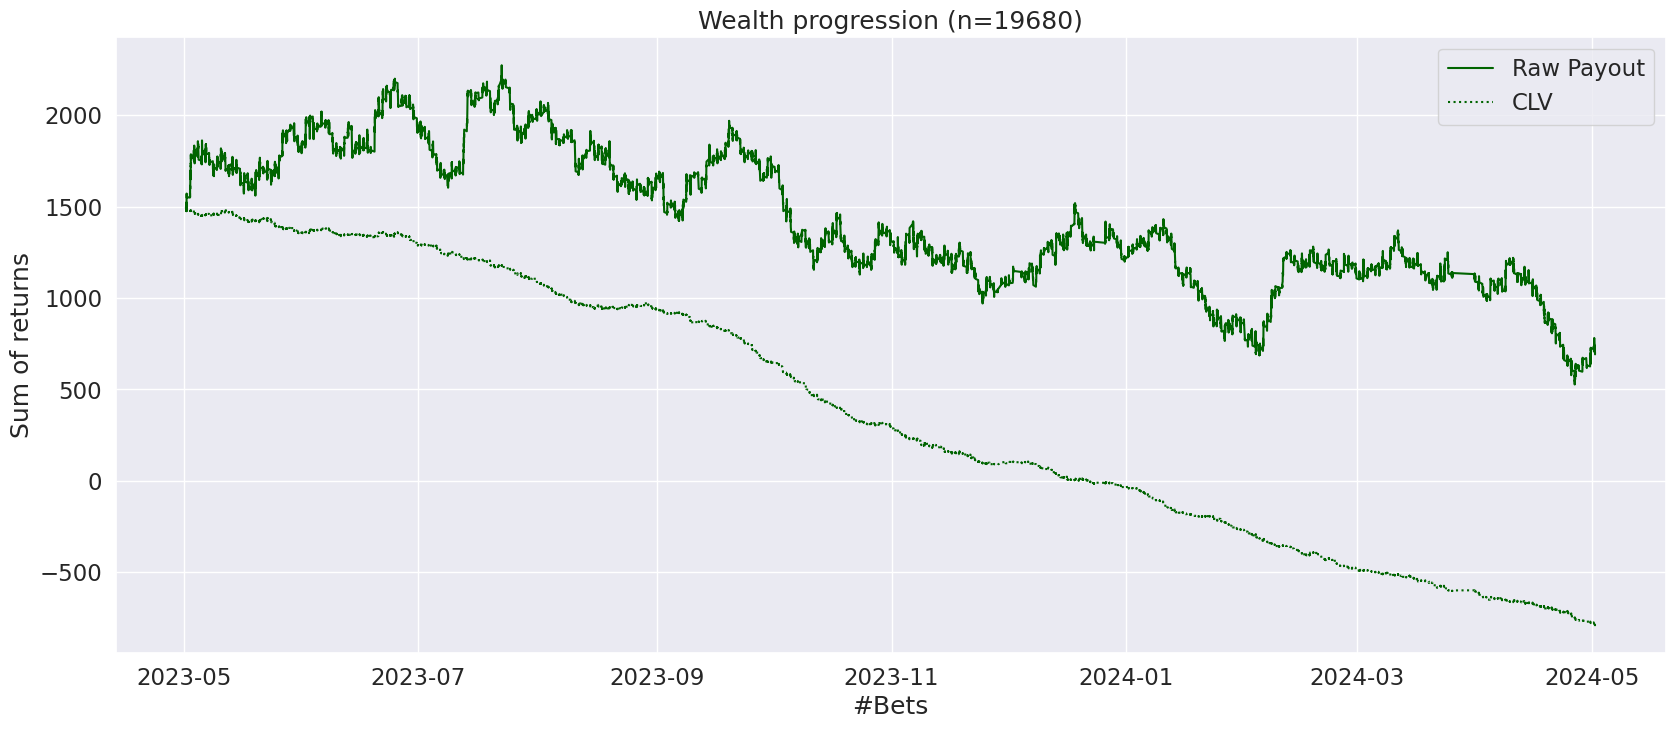

In [25]:
from Model.Betting.staking import FixedStakesCalculator, StakesCalculator, FlatStakesCalculator, KellyStakesCalculator
from util.stats_calculator import get_max_draw_down
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import log
import pandas as pd
import time

def plot_wealth_growths(test_bets: List[Bet], stakes_calculators: List[StakesCalculator]) -> None:
    bet_times = [bet.bet_offer.offer_datetime for bet in test_bets]
    colors = ["darkgreen", "yellow", "purple"]
    
    for idx, stakes_calculator in enumerate(stakes_calculators):
        for bet in test_bets:
            stakes_calculator.set_stakes(bet)
        payouts = np.array([bet.bet_offer.live_result.payout for bet in test_bets])
        soft_payouts = [bet.bet_offer.live_result.clv * bet.stakes for bet in test_bets]
        total_stakes = sum([bet.stakes for bet in test_bets])
        print(f"Yield: {sum(soft_payouts) / total_stakes}")
        max_draw_down = bet_result.max_drawdown
        print(f"Max drawdown: {max_draw_down}")
        print(f"Max draw down of soft payouts: {get_max_draw_down(soft_payouts)}")
        print(pd.Series(clv_of_bets).describe())
        
        plot_cumsum_over_time(payouts, bet_times, axes, label="Raw Payout", color=colors[idx], linestyle="-")
        plot_cumsum_over_time(soft_payouts, bet_times, axes, label="CLV", color=colors[idx], linestyle=":")
        

sns.set(rc={'figure.figsize':(10,8.5)}, font_scale=1.5)

TEST_BETS_PATH = "../data/test_payouts.dat"

with open(TEST_BETS_PATH, "rb") as f:
    bet_result = pickle.load(f)
    test_bets = bet_result.bets

test_bets = [bet for bet in test_bets if bet.bet_offer.live_result.payout != 0]
# test_bets = [bet for bet in test_bets if bet.bet_offer.minutes_until_race_start < -850]

sorted_bets = sorted(test_bets, key=lambda bet: bet.bet_offer.live_result.clv)

worst_bets = sorted_bets[:30]

for bet in worst_bets:
    print("----------------------------")
    print(bet.bet_offer.race_datetime)
    print(bet.bet_offer.horse_number)
    print(bet.probability_estimate)
    print(bet.bet_offer.live_result.clv)
    print("----------------------------")


test_bets = sorted(test_bets, key=lambda bet: bet.bet_offer.offer_datetime)

test_bets = [bet for bet in test_bets if bet.bet_offer.start_probability > -1]

fig, axes = plt.subplots(1, 1, figsize=(20, 8))
axes.set_title(f"Wealth progression (n={len(test_bets)})")
axes.set(xlabel="#Bets", ylabel="Sum of returns")

clv_of_bets = [bet.bet_offer.live_result.clv for bet in test_bets]
positive_clv_percentage = len([1 for clv in clv_of_bets if clv > 0]) / len(clv_of_bets)
print(f"% of positive clv: {positive_clv_percentage}")

stakes_calculators = [
    FixedStakesCalculator(fixed_stakes=6.0)
]

plot_wealth_growths(test_bets, stakes_calculators)


# stake_calculator = FixedStakesCalculator(fixed_stakes=8)
# for bet in test_bets:
#     stake_calculator.set_stakes(bet)
# payouts = np.array([bet.payout for bet in test_bets])
# soft_payouts = [bet.bet_offer.live_result.clv * bet.stakes for bet in test_bets]
# max_draw_down = bet_result.max_drawdown
# print(f"Max drawdown: {max_draw_down}")
# print(f"Max draw down of soft payouts: {get_max_draw_down(soft_payouts)}")
# print(pd.Series(clv_of_bets).describe())
# 
# plot_cumsum_over_time(payouts, bet_times, axes, label="Raw Payout", color="yellow", linestyle="-")
# plot_cumsum_over_time(soft_payouts, bet_times, axes, label="CLV", color="yellow", linestyle=":")

3


/tmp/ipykernel_7357/2019557435.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=n_winners_lists[0])


<AxesSubplot:ylabel='Density'>

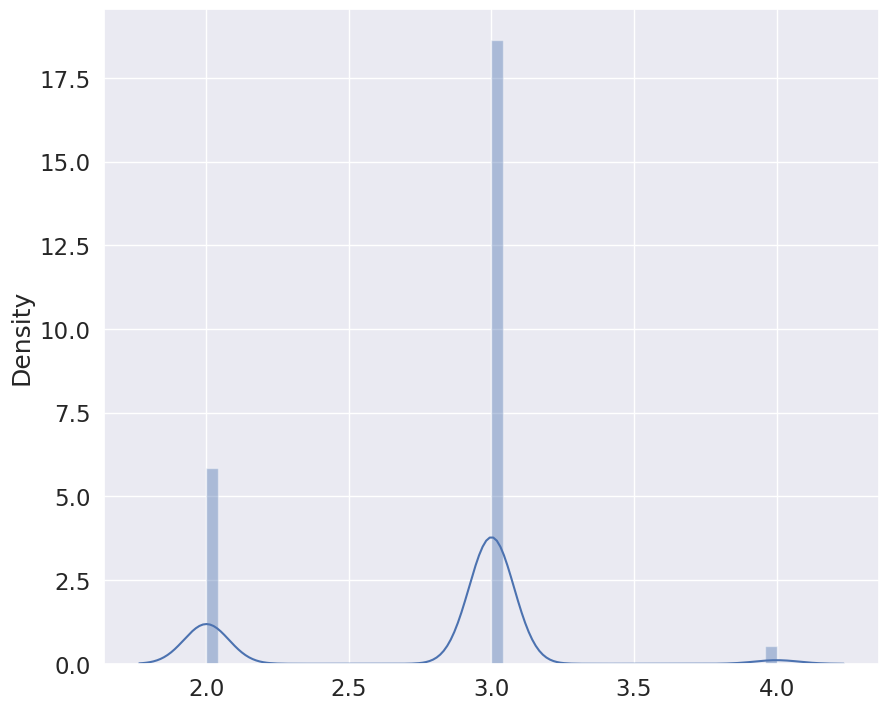

In [22]:
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

n_winners = [bet.bet_offer.n_winners for bet in test_bets]
n_winners_lists = split_list(n_winners, wanted_parts=3)
print(len(n_winners_lists))


In [4]:
from scipy.stats import pearsonr
import seaborn as sns

sp_of_bets = [bet.bet_offer.live_result.offer_odds for bet in test_bets]

sns.scatterplot(x=sp_of_bets, y=clv_of_bets)

pearsonr(x=sp_of_bets, y=clv_of_bets)

In [38]:
n_winners = [bet.bet_offer.n_winners for bet in test_bets]
sns.histplot(n_winners)

In [5]:
import numpy as np

def get_hour_difference(bet: Bet) -> int:
    return int(bet.bet_offer.minutes_until_race_start / 60)

def get_race_class(bet: Bet) -> str:
    return bet.bet_offer.race_class

def get_hour(bet: Bet) -> int:
    return bet.bet_offer.offer_datetime.hour

def get_country(bet: Bet) -> str:
    return bet.bet_offer.country

def get_month(bet: Bet) -> int:
    return bet.bet_offer.offer_datetime.month
    

def show_clvs_by_category(category_calculator):
    clvs = {}
    
    for bet in test_bets:
        category = category_calculator(bet)
        
        if category not in clvs:
            clvs[category] = []
            
        clv = bet.bet_offer.live_result.clv
        if clv != 0:
            clvs[category].append(clv)
    
    clv_means = {cat: np.mean(clvs[cat]) for cat in clvs}
    clv_counts = {cat: len(clvs[cat]) for cat in clvs}
        
    print(clv_means)
    print(clv_counts)
        
    sns.barplot(x=list(clv_means.keys()), y=list(clv_means.values()))
    
show_clvs_by_category(get_race_class)
print(len(test_bets))

In [16]:
month_count = {}

for bet in test_bets:
    month = bet.bet_offer.event_datetime.month
    if month not in month_count:
        month_count[month] = 0
    else:
        month_count[month] += 1
        
print(month_count)

In [36]:
bets = test_bets
n_successful_bets = len([bet for bet in bets if bet.payout > 0])
n_bets = len(bets)

print(n_successful_bets)
print(n_bets)
print(n_successful_bets / n_bets)
odds_positive_payout = [bet.bet_offer.live_result.offer_odds for bet in bets if bet.payout > 0]
print(np.mean(odds_positive_payout))
print(np.median([bet.bet_offer.live_result.offer_odds for bet in bets]))
print(np.mean([bet.bet_offer.live_result.offer_odds for bet in bets]))
print(np.min([bet.bet_offer.live_result.offer_odds for bet in bets]))
sns.histplot(data=odds_positive_payout, kde=True)

In [5]:
from statistics import geometric_mean, mean
from Model.Betting.bet import Bet
from typing import List
import numpy as np


def get_win_prob_diffs(bet_odds_sp_pairs: List[Tuple[float, float]]) -> List[float]:
    win_prob_diffs = []
    for odds_pair in bet_odds_sp_pairs:
        bet_odds = odds_pair[0]
        sp = odds_pair[1]
        if sp > 0:
            bet_offer_win_prob = 1 / (bet_odds * (1 - 0.025))
            bet_sp_win_prob = 1 / sp
            
            win_prob_diffs.append((bet_sp_win_prob / bet_offer_win_prob) - 1)
            
    return win_prob_diffs

bets = test_bets

cat_clv = {}
for bet in bets:
    clv = get_clv_of_bet(bet)
    cat = bet.bet_offer.race_card.category
    if cat not in cat_clv:
        cat_clv[cat] = []
        
    cat_clv[cat].append(clv)

win_prob_means = {}
win_prob_counts = {}

for race_category in cat_clv:
    win_prob_means[race_category] = mean(cat_clv[race_category])
    win_prob_counts[race_category] = len(cat_clv[race_category])

# payout_means = dict(sorted(payout_means.items(), key=lambda item: item[1]))
print(win_prob_means)
print(win_prob_counts)
# 
x = list(win_prob_means.keys())
y = list(win_prob_means.values())

sns.barplot(x=x, y=y)
# plt.ylim(0.95, 1.1)

In [97]:
import pickle
import seaborn as sns
import numpy as np

sns.set(rc={'figure.figsize':(10,8.5)}, font_scale=1.2)

TEST_BETS_PATH = "../data/test_payouts.dat"

with open(TEST_BETS_PATH, "rb") as f:
    test_bets_base = pickle.load(f)
    
test_bets_base = sorted(test_bets_base, key=lambda bet: bet.bet_offer.event_datetime)

test_bets_base = [bet for bet in test_bets_base if bet.probability_start > -1]# and bet.bet_offer.race_card.category == "HCP"]

minutes_until_race_start = [get_minutes_until_race_start(bet) for bet in test_bets_base]
ev = [(bet.probability_estimate * bet.bet_offer.odds) / bet.bet_offer.odds for bet in test_bets_base]
stakes = [bet.stakes for bet in test_bets_base]
payouts = [bet.payout for bet in test_bets_base]
np.corrcoef(stakes, ev)

In [41]:
months = [bet.bet_offer.race_card.datetime.month for bet in test_bets_base]
n_horses  = [bet.bet_offer.race_card.n_horses for bet in test_bets_base]
is_handicap = [bet.bet_offer.race_card.category == "HCP" for bet in test_bets_base]
is_track_name = [bet.bet_offer.race_card.track_name == "Exeter" for bet in test_bets_base]

print(test_bets_base[0].bet_offer.race_card.track_name)

sns.barplot(x=months, y=is_track_name)

## Displaying payouts per race category

In [47]:
import numpy as np

estimated_value = [bet.bet_offer.odds * bet.probability_estimate for bet in test_bets_base]
n_horses  = [bet.bet_offer.race_card.n_horses for bet in test_bets_base]
payouts = [bet.payout for bet in test_bets_base]

distances = [4086, 3219]
sp = [5, 34]
np.corrcoef(distances, sp)
# sns.scatterplot(x=estimated_value, y=payouts)

In [43]:
import numpy as np

payouts = {"low": [], "mid": [], "high": []}

for bet in test_bets_high_win_prob:
    odds = bet.bet_offer.odds
    
    odds_category = "low"
    if 5 <= odds <= 20:
        odds_category = "mid"
    if 20 < odds:
        odds_category = "high"
        
    payouts[odds_category].append(bet.payout)

payout_sums = {"low": 0, "mid": 0, "high": 0}
payout_counts = {"low": 0, "mid": 0, "high": 0}

for odds_category in payouts:
    payout_sums[odds_category] = np.sum(payouts[odds_category])
    payout_counts[odds_category] = len(payouts[odds_category])
    
print(payout_sums)
print(payout_counts)
    
sns.barplot(x=list(payout_sums.keys()), y=list(payout_sums.values()))

In [44]:
import numpy as np

payouts = {"low": [], "mid": [], "high": []}

for bet in test_bets_low_odds:
    prob_estimate = bet.probability_estimate

    prob_estimate_category = "low"
    if 0.05 <= prob_estimate <= 0.25:
        prob_estimate_category = "mid"
    if 0.25 < prob_estimate:
        prob_estimate_category = "high"

    payouts[prob_estimate_category].append(bet.payout)

prob_estimate_sums = {"low": 0, "mid": 0, "high": 0}
prob_estimate_counts = {"low": 0, "mid": 0, "high": 0}

for prob_estimate_category in payouts:
    prob_estimate_sums[prob_estimate_category] = np.mean(payouts[prob_estimate_category])
    prob_estimate_counts[prob_estimate_category] = len(payouts[prob_estimate_category])

print(prob_estimate_sums)
print(prob_estimate_counts)

sns.barplot(x=list(prob_estimate_sums.keys()), y=list(prob_estimate_sums.values()))

In [45]:
import numpy as np

payouts = {"low": [], "mid": [], "high": []}

for bet in test_bets_low_odds:
    prob_estimate = bet.bet_offer.adjustment_factor

    prob_estimate_category = "low"
    if 0.7 <= prob_estimate <= 0.9:
        prob_estimate_category = "mid"
    if prob_estimate < 0.7:
        prob_estimate_category = "high"

    payouts[prob_estimate_category].append(bet.payout)

prob_estimate_sums = {"low": 0, "mid": 0, "high": 0}
prob_estimate_counts = {"low": 0, "mid": 0, "high": 0}

for prob_estimate_category in payouts:
    prob_estimate_sums[prob_estimate_category] = np.mean(payouts[prob_estimate_category])
    prob_estimate_counts[prob_estimate_category] = len(payouts[prob_estimate_category])

print(prob_estimate_sums)
print(prob_estimate_counts)

sns.barplot(x=list(prob_estimate_sums.keys()), y=list(prob_estimate_sums.values()))

In [38]:
sns.histplot(payouts["mid"])

In [2]:
import sys
sys.path.append('/home/daniel/PycharmProjects/WageringSystem')

from Experiments.FundHistorySummary import FundHistorySummary
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def show_summary_grid(fund_history_summary: FundHistorySummary) -> None:
    sns.set(rc={'figure.figsize':(26,15)})
    f, axes = plt.subplots(2, 1)

    start_wealth = 1000
    bet_limit_fraction = 0.5
    show_fixed_betting_wealth_progression(axes[0], fund_history_summary, start_wealth=start_wealth, betting_limit=1000)
    show_dynamic_betting_wealth_progression(axes[1], fund_history_summary, start_wealth=start_wealth, bet_limit_fraction=bet_limit_fraction)

def show_fixed_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, betting_limit: float):
    snapshots = fund_history_summary.snapshots
    dates = [snapshot.date.split()[0] for snapshot in snapshots]
    absolute_payouts = [snapshot.payout_percentages * betting_limit for snapshot in snapshots]
    wealth_progression = [start_wealth + payout_sum for payout_sum in cumsum(absolute_payouts)]

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is: {betting_limit}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

def show_dynamic_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, bet_limit_fraction: float) -> None:
    dates = [snapshot.date.split()[0] for snapshot in fund_history_summary.snapshots]

    current_wealth = start_wealth
    wealth_progression = []
    for i in range(len(fund_history_summary.snapshots)):
        betting_limit = current_wealth * bet_limit_fraction
        current_wealth += fund_history_summary.snapshots[i].payout_percentages * betting_limit
        wealth_progression.append(current_wealth)

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is current wealth multiplied by {bet_limit_fraction:.2f}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

In [15]:
from numpy import average, mean

losses = [betting_slip.loss for betting_slip in fund_history_summary.betting_slips.values()]
payouts = [betting_slip.payout_percentage for betting_slip in fund_history_summary.betting_slips.values()]

print(f"bet rate: {fund_history_summary.bet_rate}")
print(f"max losses: {max(losses)}")
print(f"min:{min(payouts)}")
print(f"max:{max(payouts)}")
print(f"avg:{average(payouts)}")

payout_bet_count_dist = {}
payout_n_horses_dist = {}

for betting_slip in fund_history_summary.betting_slips.values():
    odds = 0
    if betting_slip.bets:
        for bet in betting_slip.bets:
            if bet.stakes_fraction > 0:
                odds = bet.odds

                odds_category = "low"
                if 2 <= odds <= 4:
                    odds_category = "mid"
                if 4 < odds:
                    odds_category = "high"
                if odds_category not in payout_bet_count_dist:
                    payout_bet_count_dist[odds_category] = {"total": bet.win - bet.loss, "n": 1}
                else:
                    payout_bet_count_dist[odds_category]["total"] += bet.win - bet.loss
                    payout_bet_count_dist[odds_category]["n"] += 1

        n_horses_category = len(betting_slip.bets)

        if n_horses_category not in payout_n_horses_dist:
            payout_n_horses_dist[n_horses_category] = 0

        payout_n_horses_dist[n_horses_category] += betting_slip.payout_percentage

for key in payout_bet_count_dist:
    if "total" in payout_bet_count_dist[key]:
        print(f"{key} count: {payout_bet_count_dist[key]['n']}")
        payout_bet_count_dist[key] = payout_bet_count_dist[key]["total"]

print(payout_bet_count_dist)
ax = sns.lineplot(data=payout_bet_count_dist)

In [16]:
ax2 = sns.lineplot(data=payout_n_horses_dist)

In [18]:
sorted_betting_slips = sorted(fund_history_summary.betting_slips.values(), key=lambda x: x.payout_percentage, reverse=True)

for betting_slip in sorted_betting_slips:
    if betting_slip.race_id == 5377715:
        print(betting_slip)

worst_betting_slips = sorted_betting_slips[-1:]

for betting_slip in worst_betting_slips:
    print(betting_slip)
    print(f"https://www.racebets.de/de/pferdewetten/race/details/id/{betting_slip.race_id}/")

In [24]:
payout_percentages = [betting_slip.payout_percentage for betting_slip in sorted_betting_slips]
odds = []
for betting_slip in sorted_betting_slips:
    if betting_slip.bets:
        odds.append(betting_slip.bets[0].predicted_horse_results[0].betting_odds)
    else:
        odds.append(0)

sns.scatterplot(x=odds, y=payout_percentages)

## Real payout plotting

In [25]:
from numpy import cumsum
import seaborn as sns
real_payouts = [
    0, 13, -6, 7, 5, 0, -1, 10, 3, 7, 1, 6, 13, 0, -5, 2, -12,
    -1, 1,
    4, 3, -5, -9, -3, -2, -4, 10, 6, -13, 4, 0, 3,
    5, 6, 14, 17, -2, -1, 2, 3, 10, -2,
    -25, -1, 3, -25, 0, -3, -19, 0, 6, 0, 28, 0, -5, -7, -6, -1, -10, 13,
]

real_payouts = [real_payout / 3 for real_payout in real_payouts]

print(cumsum(real_payouts)[-1])

ax = sns.lineplot(cumsum(real_payouts))
ax.set_title("Wealth progression")
ax.set_xlabel("N Races")
ax.set_ylabel("Wealth change in %")

In [10]:
import pandas as pd

# Create a sample dataframe with three columns 'A', 'B', and 'C'
df = pd.DataFrame({'A': [1, 1, 1, 2, 2, 2, 2, 2],
                   'B': [2, 3, 5, 10, 20, 55, 65, 75],
                   'C': [2, 2, 2, 3, 3, 3, 3, 3]})

# Group the dataframe by column 'A' and get the values of 'B' and 'C' for each group
grouped = df.groupby('A')[['B', 'C']].agg({'B': lambda x: list(x), 'C': 'first'})

# Convert the grouped values to a list of tuples
result = [tuple(row) for row in grouped.values]

print(result)

In [29]:
import pickle

BET_MODEL_CONFIGURATION_PATH = "../data/bet_model_configuration.dat"

with open(BET_MODEL_CONFIGURATION_PATH, "rb") as f:
    bet_model_configuration = pickle.load(f)

print([feature.get_name() for feature in bet_model_configuration.feature_subset])